In [94]:
import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

from tqdm import tqdm

import matplotlib.pyplot as plt

import env


In [95]:
cuda = True

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() and cuda else "cpu")

## Actor and Critic

In [97]:
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.feature = nn.Sequential(
             nn.Linear(8, 128),
             nn.ReLU(True),
        )
        self.action_layer = nn.Linear(128, 4)

    # Forward accept a tensor
    def forward(self, state):
        output_1 = self.feature(state)
        output_2 = self.action_layer(output_1)

        distribution = Categorical(F.softmax(output_2, dim=-1))
        return output_1, distribution

class Critic(nn.Module):
    def __init__(self, ):
        super(Critic, self).__init__()
        self.relu = nn.ReLU(True)
        self.linear1 = nn.Linear(128, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 1)


    # Forward accept a tensor
    def forward(self, state):
        output = self.relu(self.linear1(state))
        output = self.relu(self.linear2(output))
        output = self.linear3(output)
        return output

## Training Method

In [98]:
random_seed = 42
torch.manual_seed(random_seed)

In [105]:
def train(env, agent, optimizer, criterion, scheduler, episodes = 3000, gamma = 0.99, is_render = False, use_seed = True):
    avg_rewards,  episode_rewards= [], []
    
    for episode in  range(episodes):
        if (use_seed):
            state = env.reset()
        else:
            state = env.reset(seed = random_seed)

        total_reward = 0

        for i in range(2000):
            state = torch.FloatTensor(state).to(device)

            action = agent(state)
            state, reward, done, _ = env.step(action)
            agent.rewards.append(reward)
            total_reward += reward
            if is_render and episode % 10 == 0:
                env.render()
            if done:
                episode_rewards.append(total_reward)
                break

        # Updating the policy :
        optimizer.zero_grad()
        loss = agent.calculateLoss(criterion, gamma)
        loss.backward()
        optimizer.step()
        agent.clearMemory()
        

        lr = optimizer.param_groups[0]["lr"]
        if episode < 100 and episode % 20 == 0 and episode > 0:
             print("e: %d, lr %.4f, episode reward: %.2f," % (episode, lr, episode_rewards[-1]))

        if episode >= 100:
          avg_rewards.append(np.mean(episode_rewards[-100:]))
          if avg_rewards[-1] >= 250:
            print("Solved on episode ",episode)
            return episode_rewards, avg_rewards

        if episode % 50 == 0 and episode >= 100:
            print("e: %d, lr %.4f, episode reward: %.2f, avg reward %.2f" % (episode, lr, episode_rewards[-1], avg_rewards[-1]))

    return episode_rewards, avg_rewards

## BaseLine agent

In [100]:
class baseline(nn.Module):
    def __init__(self, actor, critic):
        super(baseline, self).__init__()
        self.actor = actor
        self.critic = critic

        self.logprobs = []
        self.state_values = []
        self.rewards = []

    def forward(self, state):
        state, distribution = self.actor(state)
        action = distribution.sample()
        
        state_value = self.critic(state)
        
        self.logprobs.append(distribution.log_prob(action))
        self.state_values.append(state_value)
        
        return action.item()
    
    def calculateLoss(self, criterion, gamma=0.99):
        rewards = []
        dis_reward = 0
        for reward in self.rewards[::-1]:
            dis_reward = reward + gamma * dis_reward
            rewards.insert(0, dis_reward)
                
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std())
        
        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            if cuda: 
                reward = reward.cuda()
            value_loss = criterion(value, reward)
            loss += (action_loss + value_loss)   
        return loss

    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]

### Enviorment 1

In [115]:
enviorment = env.LunarLander(gravity=-10.0)

In [116]:
lr = 0.02
betas = (0.9, 0.999)

actor = Actor()
critic = Critic()
base_agent = baseline(actor, critic)

criterion = nn.SmoothL1Loss()
decayRate = 0.98
optimizer = optim.Adam(base_agent.parameters(), lr=lr, betas=betas)
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [117]:
if (cuda):
    actor = actor.cuda()
    critic = critic.cuda()
    base_agent = base_agent.cuda()
    criterion = criterion.cuda()

In [118]:
rew1, avg1 = train(enviorment, base_agent, optimizer, criterion, my_lr_scheduler, episodes = 2000)

C:\Users\55366\anaconda3\envs\ml\lib\site-packages\torch\nn\modules\loss.py:921: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


e: 20, lr 0.0200, episode reward: -550.44,
e: 40, lr 0.0200, episode reward: -649.55,
e: 60, lr 0.0200, episode reward: -590.98,
e: 80, lr 0.0200, episode reward: -388.12,
e: 100, lr 0.0200, episode reward: -147.95, avg reward -458.00
e: 150, lr 0.0200, episode reward: -181.45, avg reward -237.06
e: 200, lr 0.0200, episode reward: -110.83, avg reward -182.30
e: 250, lr 0.0200, episode reward: -126.18, avg reward -166.84
e: 300, lr 0.0200, episode reward: -136.44, avg reward -174.87
e: 350, lr 0.0200, episode reward: -129.53, avg reward -173.79
e: 400, lr 0.0200, episode reward: -170.33, avg reward -124.87
e: 450, lr 0.0200, episode reward: -8.42, avg reward -86.68
e: 500, lr 0.0200, episode reward: -230.26, avg reward -104.47
e: 550, lr 0.0200, episode reward: -104.27, avg reward -163.55
e: 600, lr 0.0200, episode reward: -15.66, avg reward -109.83
e: 650, lr 0.0200, episode reward: -113.51, avg reward -6.85
e: 700, lr 0.0200, episode reward: 22.00, avg reward 15.00
e: 750, lr 0.0200, 

KeyboardInterrupt: 

In [41]:
torch.save(actor, "./model_weight/base_actor")
torch.save(critic, "./model_weight/base_critic")

Text(0.5, 1.0, 'LunarLander env (average reward)')

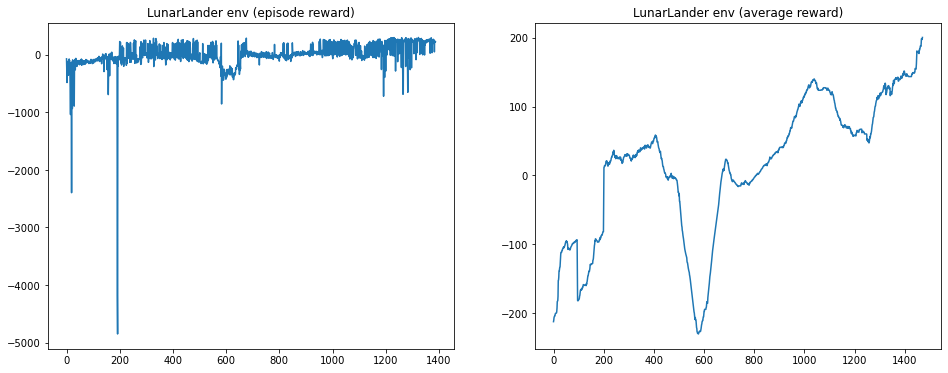

In [42]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 6))
ax1.plot(rew1)
ax1.set_title("LunarLander env (episode reward)")
ax2.plot(avg1)
ax2.set_title("LunarLander env (average reward)")

### Enviorment 2

In [43]:
enviorment_wind = env.LunarLander(gravity=-10.0, enable_wind=True, wind_power = 5.0)

In [44]:
actor_wind = Actor()
critic_wind = Critic()
base_agent_wind = baseline(actor_wind, critic_wind)

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(base_agent_wind.parameters(), lr=lr, betas=betas)
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [45]:
if (cuda):
    actor_wind = actor_wind.cuda()
    critic_wind = critic_wind.cuda()
    base_agent_wind = base_agent_wind.cuda()
    criterion = criterion.cuda()

In [46]:
rew2, avg2 = train(enviorment_wind, base_agent_wind, optimizer, criterion, my_lr_scheduler)

e: 20, lr 0.0200, episode reward: -152.10,
e: 40, lr 0.0200, episode reward: -97.86,
e: 60, lr 0.0200, episode reward: -198.69,
e: 80, lr 0.0200, episode reward: -304.69,
e: 100, lr 0.0200, episode reward: -553.62, avg reward -234.81
e: 150, lr 0.0200, episode reward: -734.56, avg reward -528.19
e: 200, lr 0.0200, episode reward: -639.03, avg reward -693.52
e: 250, lr 0.0200, episode reward: -967.69, avg reward -597.04
e: 300, lr 0.0200, episode reward: -806.54, avg reward -460.61
e: 350, lr 0.0200, episode reward: -231.66, avg reward -354.34
e: 400, lr 0.0200, episode reward: -68.64, avg reward -203.24
e: 450, lr 0.0200, episode reward: 163.93, avg reward -75.80
e: 500, lr 0.0200, episode reward: -3.37, avg reward -77.38
e: 550, lr 0.0200, episode reward: -89.39, avg reward -69.10
e: 600, lr 0.0200, episode reward: 207.11, avg reward -18.60
e: 650, lr 0.0200, episode reward: 170.85, avg reward 19.94
e: 700, lr 0.0200, episode reward: -51.57, avg reward 20.05
e: 750, lr 0.0200, episode

Text(0.5, 1.0, 'LunarLander env2 (average reward)')

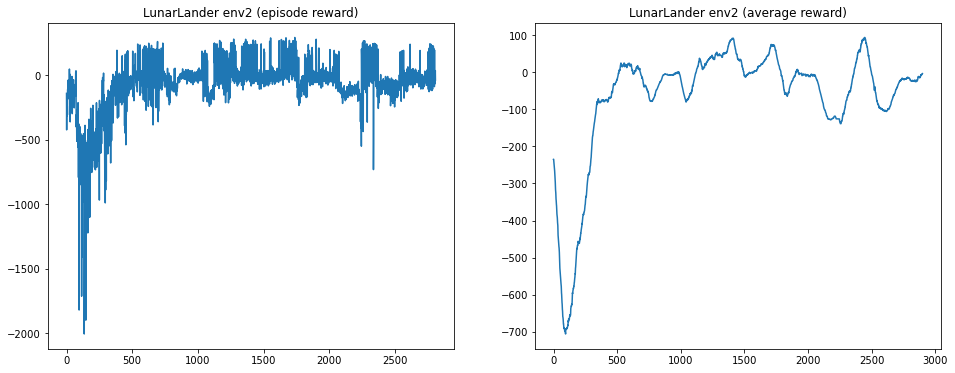

In [47]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 6))
ax1.plot(rew2)
ax1.set_title("LunarLander env2 (episode reward)")
ax2.plot(avg2)
ax2.set_title("LunarLander env2 (average reward)")

In [48]:
torch.save(actor_wind, "./model_weight/base_wind_actor")
torch.save(critic_wind, "./model_weight/base_wind_critic")

## First attempt
Load The last layer of critic

### Env1 to Env2

In [49]:
actor_state_dict = torch.load('./model_weight/base_actor')
critic_state_dict = torch.load('./model_weight/base_critic')

In [50]:
actor_2 = torch.load('./model_weight/base_actor')
critic_2 = Critic()
with torch.no_grad():
    critic_2.linear3.weight.copy_(critic_state_dict.linear3.weight)
    critic_2.linear3.bias.copy_(critic_state_dict.linear3.bias)

In [51]:
agent_2 = baseline(actor_2, critic_2)

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(agent_2.parameters(), lr=lr, betas=betas)
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [52]:
if (cuda):
    actor_2 = actor_2.cuda()
    critic_2 = critic_2.cuda()
    agent_2 = agent_2.cuda()
    criterion = criterion.cuda()

In [53]:
rew4, avg4 = train(enviorment_wind, agent_2, optimizer, criterion, my_lr_scheduler)

e: 20, lr 0.0200, episode reward: 218.93,
e: 40, lr 0.0200, episode reward: 58.02,
e: 60, lr 0.0200, episode reward: 6.49,
e: 80, lr 0.0200, episode reward: -54.85,
e: 100, lr 0.0200, episode reward: -59.05, avg reward 115.26
e: 150, lr 0.0200, episode reward: 16.74, avg reward 30.20
e: 200, lr 0.0200, episode reward: -385.72, avg reward 0.80
e: 250, lr 0.0200, episode reward: 293.91, avg reward -27.88
e: 300, lr 0.0200, episode reward: 235.04, avg reward 8.65
e: 350, lr 0.0200, episode reward: -50.32, avg reward 66.17
e: 400, lr 0.0200, episode reward: 9.19, avg reward 67.88
e: 450, lr 0.0200, episode reward: -34.04, avg reward 64.09
e: 500, lr 0.0200, episode reward: -27.34, avg reward 90.61
e: 550, lr 0.0200, episode reward: -28.25, avg reward 76.86
e: 600, lr 0.0200, episode reward: 263.66, avg reward 47.06
e: 650, lr 0.0200, episode reward: -40.87, avg reward 63.39
e: 700, lr 0.0200, episode reward: 95.08, avg reward 112.26
e: 750, lr 0.0200, episode reward: -65.36, avg reward -19

Text(0.5, 1.0, 'first attempt env1 to env2 (average reward)')

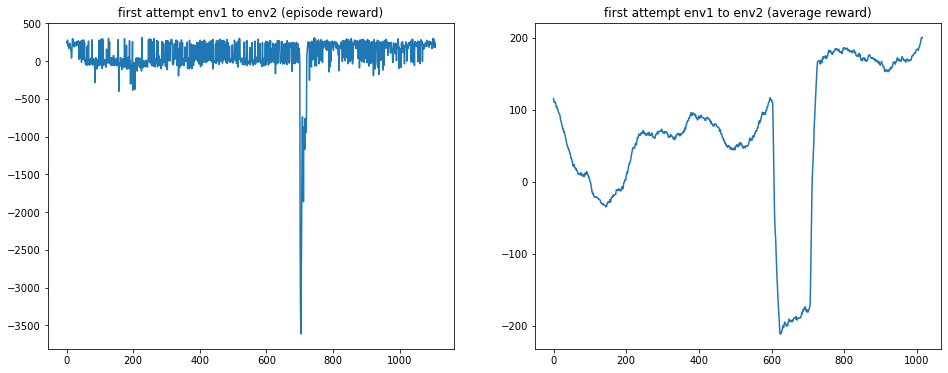

In [54]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 6))
ax1.plot(rew4)
ax1.set_title("first attempt env1 to env2 (episode reward)")
ax2.plot(avg4)
ax2.set_title("first attempt env1 to env2 (average reward)")

### Env2 to Env1

In [55]:
actor_state_dict = torch.load('./model_weight/base_wind_actor')
critic_state_dict = torch.load('./model_weight/base_wind_critic')

In [56]:
actor_3 = torch.load('./model_weight/base_wind_actor')
critic_3 = Critic()
with torch.no_grad():
    critic_3.linear3.weight.copy_(critic_state_dict.linear3.weight)
    critic_3.linear3.bias.copy_(critic_state_dict.linear3.bias)

In [57]:
agent_3 = baseline(actor_3, critic_3)

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(agent_3.parameters(), lr=lr, betas=betas)
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [58]:
if (cuda):
    actor_3 = actor_3.cuda()
    critic_3 = critic_3.cuda()
    agent_3 = agent_3.cuda()
    criterion = criterion.cuda()

In [59]:
rew5, avg5 = train(enviorment, agent_3, optimizer, criterion, my_lr_scheduler)

e: 20, lr 0.0200, episode reward: -55.13,
e: 40, lr 0.0200, episode reward: -76.64,
e: 60, lr 0.0200, episode reward: -43.24,
e: 80, lr 0.0200, episode reward: -58.78,
e: 100, lr 0.0200, episode reward: 9.05, avg reward -18.74
e: 150, lr 0.0200, episode reward: 31.48, avg reward -2.91
e: 200, lr 0.0200, episode reward: 11.36, avg reward 15.52
e: 250, lr 0.0200, episode reward: -2.56, avg reward 18.37
e: 300, lr 0.0200, episode reward: -11.35, avg reward 16.19
e: 350, lr 0.0200, episode reward: -41.97, avg reward -16.81
e: 400, lr 0.0200, episode reward: -106.55, avg reward -56.41
e: 450, lr 0.0200, episode reward: -52.45, avg reward -1.86
e: 500, lr 0.0200, episode reward: -65.58, avg reward 54.73
e: 550, lr 0.0200, episode reward: -39.42, avg reward 69.83
e: 600, lr 0.0200, episode reward: 273.16, avg reward 80.30
e: 650, lr 0.0200, episode reward: -6.57, avg reward 63.01
e: 700, lr 0.0200, episode reward: 3.52, avg reward 8.26
e: 750, lr 0.0200, episode reward: -5.65, avg reward 11.7

Text(0.5, 1.0, 'first attempt env1 to env2 (average reward)')

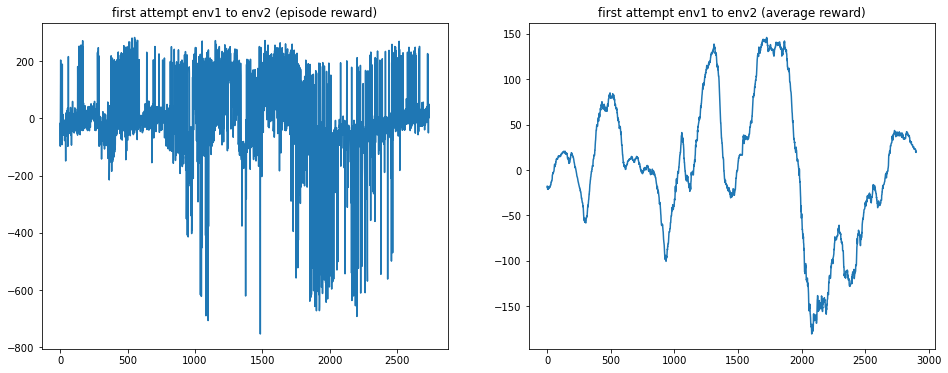

In [60]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 6))
ax1.plot(rew5)
ax1.set_title("first attempt env1 to env2 (episode reward)")
ax2.plot(avg5)
ax2.set_title("first attempt env1 to env2 (average reward)")

## Second attempt

### Env1 to env2

In [106]:
actor_state_dict = torch.load('./model_weight/base_actor')
critic_state_dict = torch.load('./model_weight/base_critic')

In [107]:
actor_4 = torch.load('./model_weight/base_actor')
critic_4 = Critic()
with torch.no_grad():
    critic_4.linear2.weight.copy_(critic_state_dict.linear2.weight)
    critic_4.linear2.bias.copy_(critic_state_dict.linear2.bias)

    critic_4.linear3.weight.copy_(critic_state_dict.linear3.weight)
    critic_4.linear3.bias.copy_(critic_state_dict.linear3.bias)

In [108]:
agent_4 = baseline(actor_4, critic_4)

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(agent_4.parameters(), lr=lr, betas=betas)
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [109]:
if (cuda):
    actor_4 = actor_4.cuda()
    critic_4 = critic_4.cuda()
    agent_4 = agent_4.cuda()
    criterion = criterion.cuda()

In [110]:
rew6, avg6 = train(enviorment_wind, agent_4, optimizer, criterion, my_lr_scheduler)

e: 20, lr 0.0200, episode reward: 206.28,
e: 40, lr 0.0200, episode reward: 210.06,
e: 60, lr 0.0200, episode reward: -36.20,
e: 80, lr 0.0200, episode reward: 210.68,
e: 100, lr 0.0200, episode reward: 235.84, avg reward 173.45
e: 150, lr 0.0200, episode reward: -0.37, avg reward 112.31
e: 200, lr 0.0200, episode reward: 213.42, avg reward 79.39
e: 250, lr 0.0200, episode reward: 217.66, avg reward 90.50
e: 300, lr 0.0200, episode reward: 202.65, avg reward 112.90
e: 350, lr 0.0200, episode reward: 5.77, avg reward 78.04
e: 400, lr 0.0200, episode reward: -49.96, avg reward 25.70
e: 450, lr 0.0200, episode reward: -39.50, avg reward 6.22
e: 500, lr 0.0200, episode reward: 274.60, avg reward 11.83
e: 550, lr 0.0200, episode reward: 283.62, avg reward 68.35
e: 600, lr 0.0200, episode reward: 6.09, avg reward 105.37
e: 650, lr 0.0200, episode reward: -20.17, avg reward 37.36
e: 700, lr 0.0200, episode reward: -35.69, avg reward -20.87
e: 750, lr 0.0200, episode reward: 305.86, avg reward

### Env2 to env1

In [66]:
actor_state_dict = torch.load('./model_weight/base_wind_actor')
critic_state_dict = torch.load('./model_weight/base_wind_critic')

In [67]:
actor_5 = torch.load('./model_weight/base_wind_actor')
critic_5 = Critic()
with torch.no_grad():
    critic_5.linear2.weight.copy_(critic_state_dict.linear2.weight)
    critic_5.linear2.bias.copy_(critic_state_dict.linear2.bias)

    critic_5.linear3.weight.copy_(critic_state_dict.linear3.weight)
    critic_5.linear3.bias.copy_(critic_state_dict.linear3.bias)

In [68]:
agent_5 = baseline(actor_5, critic_5)

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(agent_5.parameters(), lr=lr, betas=betas)
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [69]:
if (cuda):
    actor_5 = actor_5.cuda()
    critic_5 = critic_5.cuda()
    agent_5 = agent_5.cuda()
    criterion = criterion.cuda()

In [70]:
rew7, avg7 = train(enviorment, agent_5, optimizer, criterion, my_lr_scheduler, episodes = 3000)

e: 20, lr 0.0200, episode reward: 204.49,
e: 40, lr 0.0200, episode reward: 242.72,
e: 60, lr 0.0200, episode reward: 187.22,
e: 80, lr 0.0200, episode reward: 5.61,
e: 100, lr 0.0200, episode reward: -31.50, avg reward 90.55
e: 150, lr 0.0200, episode reward: -25.04, avg reward 120.90
e: 200, lr 0.0200, episode reward: 56.01, avg reward 97.20
e: 250, lr 0.0200, episode reward: 231.02, avg reward 87.21
e: 300, lr 0.0200, episode reward: -40.56, avg reward 67.87
e: 350, lr 0.0200, episode reward: -11.43, avg reward 64.24
e: 400, lr 0.0200, episode reward: -36.72, avg reward 44.84
e: 450, lr 0.0200, episode reward: -46.33, avg reward 55.20
e: 500, lr 0.0200, episode reward: 242.11, avg reward 88.28
e: 550, lr 0.0200, episode reward: 31.74, avg reward 113.45
e: 600, lr 0.0200, episode reward: 246.64, avg reward 119.66
e: 650, lr 0.0200, episode reward: 7.31, avg reward 76.99
e: 700, lr 0.0200, episode reward: 232.53, avg reward 54.53
e: 750, lr 0.0200, episode reward: -40.04, avg reward 3

# Third Attempt

In [122]:
class Critic_2(nn.Module):
    def __init__(self, ):
        super(Critic_2, self).__init__()
        self.relu = nn.ReLU(True)
        self.linear0 = nn.Linear(128, 128)
        self.linear1 = nn.Linear(128, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 1)


    # Forward accept a tensor
    def forward(self, state):
        output = self.relu(self.linear0(state))
        output = self.relu(self.linear1(output))
        output = self.relu(self.linear2(output))
        output = self.linear3(output)
        return output

In [123]:
actor_state_dict = torch.load('./model_weight/base_actor')
critic_state_dict = torch.load('./model_weight/base_critic')

In [124]:
actor_6 = torch.load('./model_weight/base_wind_actor')
critic_6 = Critic_2()
with torch.no_grad():
    critic_6.linear1.weight.copy_(critic_state_dict.linear1.weight)
    critic_6.linear1.bias.copy_(critic_state_dict.linear1.bias)

    critic_6.linear2.weight.copy_(critic_state_dict.linear2.weight)
    critic_6.linear2.bias.copy_(critic_state_dict.linear2.bias)

    critic_6.linear3.weight.copy_(critic_state_dict.linear3.weight)
    critic_6.linear3.bias.copy_(critic_state_dict.linear3.bias)

In [125]:
agent_6 = baseline(actor_6, critic_6)

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(agent_6.parameters(), lr=lr, betas=betas)
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [126]:
if (cuda):
    agent_6 = agent_6.cuda()
    critic_6 = critic_6.cuda()
    actor_6 = actor_6.cuda()
    criterion = criterion.cuda()

In [127]:
rew8, avg8 = train(enviorment, agent_6, optimizer, criterion, my_lr_scheduler, episodes = 3000)

e: 20, lr 0.0200, episode reward: 19.88,
e: 40, lr 0.0200, episode reward: -3.87,
e: 60, lr 0.0200, episode reward: 15.73,
e: 80, lr 0.0200, episode reward: 31.97,
e: 100, lr 0.0200, episode reward: -21.34, avg reward 8.52
e: 150, lr 0.0200, episode reward: -20.19, avg reward 15.70
e: 200, lr 0.0200, episode reward: 3.84, avg reward 7.16
e: 250, lr 0.0200, episode reward: 28.08, avg reward 20.80
e: 300, lr 0.0200, episode reward: 248.53, avg reward 38.92
e: 350, lr 0.0200, episode reward: -1.45, avg reward 14.29
e: 400, lr 0.0200, episode reward: -124.89, avg reward -4.36
e: 450, lr 0.0200, episode reward: 21.73, avg reward -92.06
e: 500, lr 0.0200, episode reward: -160.79, avg reward -157.22
e: 550, lr 0.0200, episode reward: -139.04, avg reward -150.03
e: 600, lr 0.0200, episode reward: -171.17, avg reward -148.17
e: 650, lr 0.0200, episode reward: -141.90, avg reward -137.10
e: 700, lr 0.0200, episode reward: -95.51, avg reward -130.69
e: 750, lr 0.0200, episode reward: -87.26, avg 

## Results

Text(0.5, 1.0, 'Wind Envioremnt  (gravity = -10, wind = 5)')

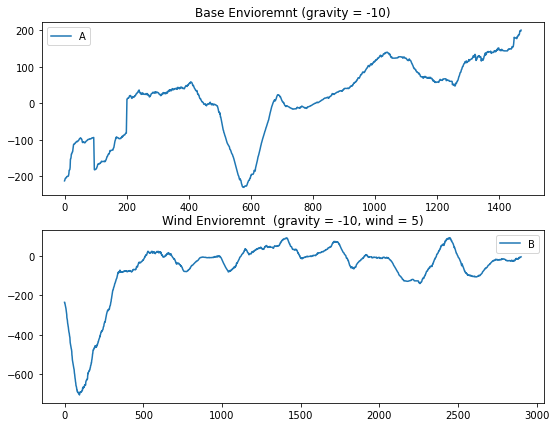

In [86]:
f, (ax1, ax2) = plt.subplots(2, 1,figsize=(9, 7))
ax1.plot(avg1)
ax1.legend(['A'])
ax1.set_title("Base Envioremnt (gravity = -10)")
ax2.plot(avg2)
ax2.legend(['B'])
ax2.set_title("Wind Envioremnt  (gravity = -10, wind = 5)")

Text(0.5, 1.0, 'Wind Envioremnt  (gravity = -10, wind = 5)')

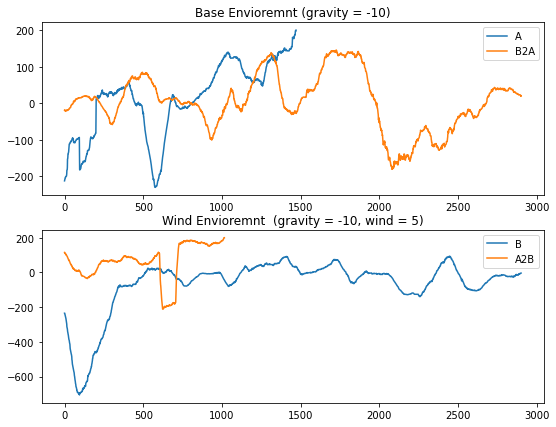

In [87]:
f, (ax1, ax2) = plt.subplots(2, 1,figsize=(9, 7))
ax1.plot(avg1)
ax1.plot(avg5)
ax1.legend(['A', 'B2A'])
ax1.set_title("Base Envioremnt (gravity = -10)")
ax2.plot(avg2)
ax2.plot(avg4)
ax2.legend(['B', 'A2B'])
ax2.set_title("Wind Envioremnt  (gravity = -10, wind = 5)")

Text(0.5, 1.0, 'Wind Envioremnt  (gravity = -10, wind = 5)')

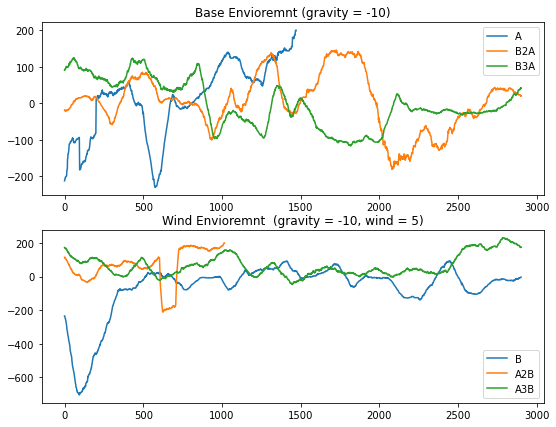

In [114]:
f, (ax1, ax2) = plt.subplots(2, 1,figsize=(9, 7))
ax1.plot(avg1)
ax1.plot(avg5)
ax1.plot(avg7)
ax1.legend(['A', 'B2A', 'B3A'])
ax1.set_title("Base Envioremnt (gravity = -10)")
ax2.plot(avg2)
ax2.plot(avg4)
ax2.plot(avg6)
ax2.legend(['B', 'A2B', 'A3B'])
ax2.set_title("Wind Envioremnt  (gravity = -10, wind = 5)")